In [8]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy import mean
from numpy import std
from numpy import array
from matplotlib import pyplot
import numpy
import pandas as pd

In [9]:
def parser(x):
    return datetime.strptime(x, '%m/%d/%Y')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [10]:
# load datasets
# training dataset
sars = read_csv('./data/sars_canada.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)['cumulative_cases']
# test dataset
covid = read_csv('./data/covid_canada.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)['cumulative_cases']

series = sars.append(covid)
series

date
2003-03-17        8
2003-03-18        8
2003-03-19        8
2003-03-20        9
2003-03-21        9
              ...  
2020-05-07    63496
2020-05-08    64922
2020-05-09    66434
2020-05-10    67702
2020-05-11    68848
Name: cumulative_cases, Length: 229, dtype: int64

In [11]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-133], supervised_values[-133:]

In [12]:
def walk_forward_validation():
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 100, 100)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]
    
    print('Actual: ' + f'{raw_values[len(raw_values) - 1]}')
    print('Predicted: %.0f' % (predictions[len(predictions) - 1]))

    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-133:], predictions))
    print('Error: %.3f' % rmse)
    # line plot of observed vs predicted
    pyplot.plot(raw_values[-133:])
    pyplot.plot(predictions)
    pyplot.show()

    return rmse

In [13]:
# Repeated evaluation
def repeat_evaluation(n_repeats):
    score_list = list()

    for i in range(n_repeats):
        print('\nIteration: %.0f' % (i + 1))
        score_list.append(walk_forward_validation())

    return score_list

# Summarize model
def summarize(name, score_list):
    score_m, score_std = mean(score_list), std(score_list)
    print('\n%s: %.3f RMSE (+/- %.3f)' % (name, score_m, score_std))

    # Create box and whisker plot
    pyplot.boxplot(score_list)
    pyplot.show()


Iteration: 1
Actual: 68848
Predicted: 67686
Error: 879.524


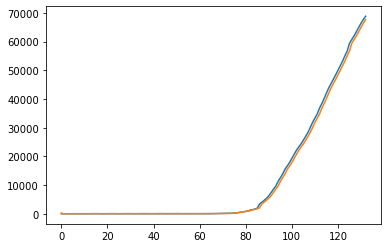


Iteration: 2
Actual: 68848
Predicted: 67710
Error: 870.084


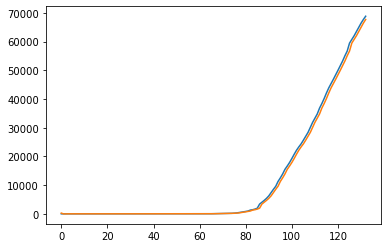


Iteration: 3
Actual: 68848
Predicted: 67685
Error: 884.761


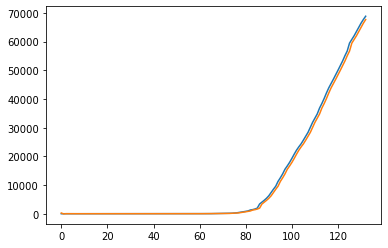


Iteration: 4
Actual: 68848
Predicted: 67697
Error: 877.924


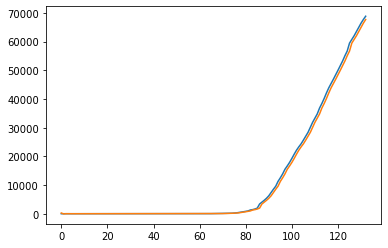


Iteration: 5
Actual: 68848
Predicted: 67674
Error: 891.739


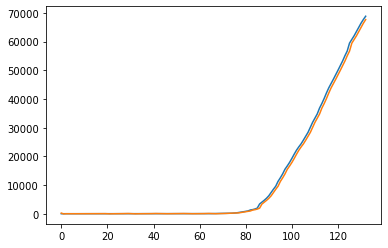


Iteration: 6
Actual: 68848
Predicted: 67682
Error: 886.736


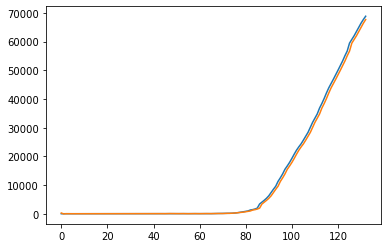


Iteration: 7
Actual: 68848
Predicted: 67707
Error: 873.324


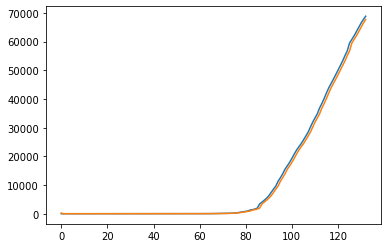


Iteration: 8
Actual: 68848
Predicted: 67697
Error: 869.401


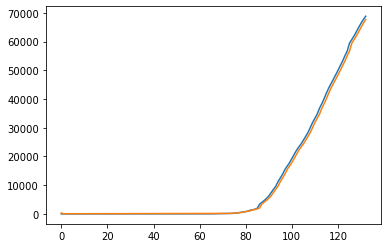


Iteration: 9
Actual: 68848
Predicted: 67684
Error: 885.730


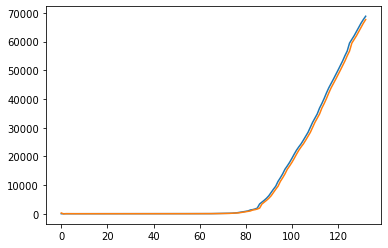


Iteration: 10
Actual: 68848
Predicted: 67688
Error: 883.561


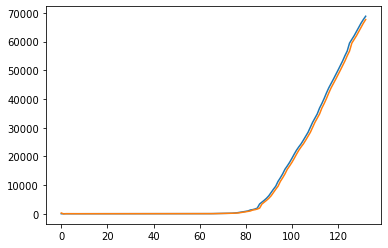


LSTM: 880.278 RMSE (+/- 7.144)


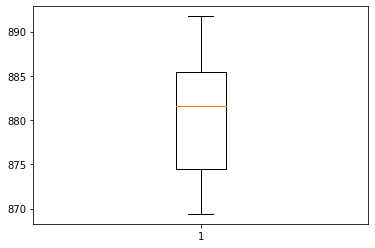

In [14]:
# Create and fit model
# Error is calculate throughout the entire prediction period
score_list = repeat_evaluation(10)
summarize('LSTM', score_list)